# **Business Problem** 


## Problem Stement

The problem statement is to make a bot detection model to successfully separate humans from bots from an online biding war site. This problem is causing the human bidders to be losing bidding wars with software-based counters causing frustration and loss to the bidders.



## Source/Dataset:

https://www.kaggle.com/c/facebook-recruiting-iv-human-or-bot/

## Business Objectives/constraints:



*   The objective is to find a profitable trading model that can give a profittable output, hence the prediction has to be very fast(in milliseconds)
*   The evaluation metric used is AUC ROC.
* **AUC score** is a very valid evaluation metric considering it has been used as an evaluation metric, but on a real world case problem we would be more concerned about the **Recall**, as we would want most if not all bots to be classified correctly and not miss-classified as humans



# **Data Cleaning**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd '/content/gdrive/My Drive/self_case_study_1'
import warnings
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score as roc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

Mounted at /content/gdrive
/content/gdrive/My Drive/self_case_study_1


In [2]:
train = pd.read_csv('train.csv')
bids = pd.read_csv('bids.csv')

In [3]:
train.head()

,bidder_id,payment_account,address,outcome
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0


In [ ]:
bids.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,home goods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3




*   From initial impression, we are not able to make any features out of the "train" dataframe because as we can see we have payment account and address which seem to be encrypted, but we have our target variable for our unique bidder ids.
*   The bids seem to have very interesting features all the bids from each bidder participated with time variable for us to hold sequence information. We also have features inclusing merchandize on which the bid was placed, the device, the country, the ip and the url for every bid which could be leveraged to make features



In [ ]:
dataset = train.merge(bids, on = 'bidder_id', how = 'left')
dataset.isnull().any()

bidder_id          False
payment_account    False
address            False
outcome            False
bid_id              True
auction             True
merchandise         True
device              True
time                True
country             True
ip                  True
url                 True
dtype: bool

In [ ]:
missing_bids = dataset[dataset['bid_id'].isnull()]
missing_bids.head()

,bidder_id,payment_account,address,outcome,bid_id,auction,merchandise,device,time,country,ip,url
17583,5f50c6187a179e2ee7ba2fbcfc845c7a1smgr,7326f0a1592b18cb1e6ed7c8ebbd03a72qf7p,a3d2de7675556553a5f08e4c88d2c228uaoqg,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42424,02bde521e763e4f4e590e8368149e04a96il9,a3d2de7675556553a5f08e4c88d2c2286r1lb,935d2083173e96f099816c1b1f7ee249kk8zo,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129439,dd661e2d6e79a5b3e66c82373d50f3ee86k85,e805bf9d2399ddc37a194e04703a333c7bv82,2c2b8b44b1615ef6d632fb115a85794djmktr,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214915,908ce7060337fd8550760a100921f6f7wsemn,a3d2de7675556553a5f08e4c88d2c2282yldz,39b2bdec29461f8a0ae2a5a5b01d259fik8r7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
221776,b64c209b3d1d91a663d134961af89125u0s9a,f7558102989f5665bbbea00358f8434adf9o9,5c9de1da50cc32a29ffd596ae24cd2be24cly,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print('Missing Bids Data:',missing_bids.shape[0])
print('Missing Data with outcome as bots:',missing_bids[missing_bids['outcome']==1].shape[0])
cleaned_data = dataset[~dataset['bidder_id'].isin(missing_bids['bidder_id'])]
cleaned_data.isnull().any()

Missing Bids Data: 29
Missing Data with outcome as bots: 0


bidder_id          False
payment_account    False
address            False
outcome            False
bid_id             False
auction            False
merchandise        False
device             False
time               False
country             True
ip                 False
url                False
dtype: bool


* As observed we have 29 bidders data without data about their bids but we can see that none of them are part of the bots category hence, we are going to remove such data and proceed with the rest.

* After cleaning the data with bidders without bids we observe that the data has missing country values.



Text(0.5, 1.0, 'Country Count Plot')

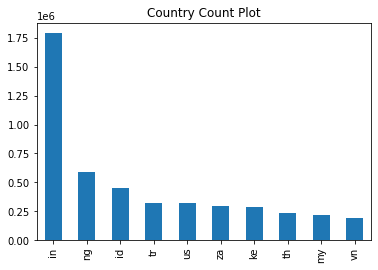

In [ ]:
# The country with highest number of bids in the dataset in general
bids['country'].value_counts()[:10].plot(kind="bar")
plt.title('Country Count Plot')

In [ ]:
#Creating Lookup table for missing country values and filling based on the dominating(higher frequency) country for the bidder
lookup = pd.DataFrame(bids.groupby(['bidder_id'])['country'].value_counts())
lookup.columns = ['count']
lookup = lookup.reset_index().groupby('bidder_id').first().reset_index().drop('count',axis=1)
lookup.head(5)

,bidder_id,country
0,001068c415025a009fee375a12cff4fcnht8y,bn
1,002d229ffb247009810828f648afc2ef593rb,sg
2,0030a2dd87ad2733e0873062e4f83954mkj86,ir
3,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,id
4,00486a11dff552c4bd7696265724ff81yeo9v,ng


In [ ]:
# Function that fills the empty country values with reference to lookup table or fills default as "in"
def fill_country(data):
  if data['country']!=data['country']:
      if data['bidder_id'] in list(lookup['bidder_id']):
            data['country'] = lookup[lookup['bidder_id']==data['bidder_id']]['country'].values[0]
      else:
        data['country'] = 'in'
  return data

In [ ]:
cleaned_data = cleaned_data.apply(lambda x:fill_country(x),axis=1)
cleaned_bids = bids.apply(lambda x:fill_country(x),axis=1)
with open('dataset.pkl', 'wb') as output_file:
    pkl.dump(cleaned_data, output_file)
with open('cleaned_bids.pkl', 'wb') as output_file:
    pkl.dump(cleaned_bids, output_file)

* As seen above there was country data missing, hence to fill the data we created a lookup table. This lookup table shows the country each bidder bids from the highest number of times.
* In case, the lookup table had missing bidder values, we were able to abserve "in" had highest bids, hence we have set the default value as "in", in case the bidder_id isn't present in the lookup table

# **Data Analysis**

In [4]:
df = pd.read_pickle('dataset.pkl')
train = pd.read_csv('train.csv')
bids = pd.read_csv('bids.csv')
train['outcome_label'] = train['outcome'].apply(lambda x: 'human' if x==0 else 'bot')
df['outcome_label'] = df['outcome'].apply(lambda x: 'human' if x==0 else 'bot')
df.head()

,bidder_id,payment_account,address,outcome,bid_id,auction,merchandise,device,time,country,ip,url,outcome_label
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,85371.0,yitr4,home goods,phone35,9.759489e+15,ke,82.34.177.248,vasstdc27m7nks3,human
1,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,274487.0,btpyy,home goods,phone1004,9.760249e+15,zm,202.130.71.167,vasstdc27m7nks3,human
2,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,527436.0,kj2ko,home goods,phone4,9.762261e+15,ke,22.54.76.225,vasstdc27m7nks3,human
3,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,554135.0,1m5t8,home goods,phone4,9.762431e+15,ke,32.13.237.126,vasstdc27m7nks3,human
4,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,607628.0,btpyy,home goods,phone4,9.762789e+15,ke,202.236.188.240,vasstdc27m7nks3,human


## Outcome

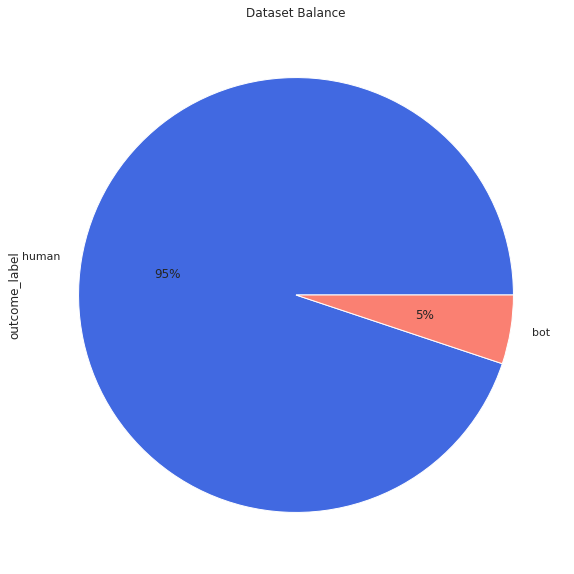

In [ ]:
train['outcome_label'].value_counts().plot.pie(figsize=(10, 10),autopct='%1.0f%%',title='Dataset Balance',colors= ['royalblue','salmon'])



*   This is a highly imbalanced dataset with 5% dataset as bot as seen in the pie chart



## Merchandize

Text(0.5, 1.0, 'Percentage bids of Merchandise')

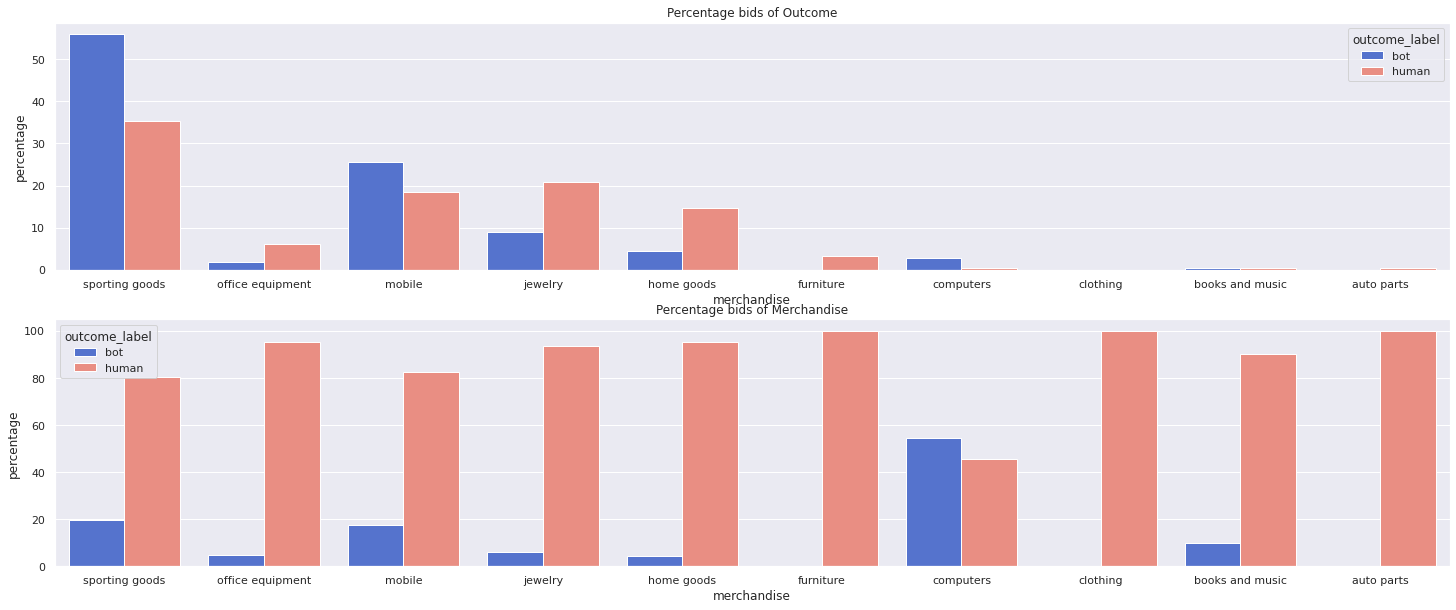

In [ ]:
# Refrence: https://stackoverflow.com/questions/34615854/seaborn-countplot-with-normalized-y-axis-per-group
# Percentage of humans vs bots bidding in each merchandize
outcome_counts = (df.groupby(['outcome_label'])['merchandise']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('merchandise',ascending=False))
merchandise_counts = (df.groupby(['merchandise'])['outcome_label']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('merchandise',ascending=False))
sns.set(rc={'figure.figsize':(18,15)})
fig, axes = plt.subplots(2,1, figsize=(25, 10))
sns.barplot(x="merchandise", y="percentage", hue="outcome_label", data=outcome_counts,palette = ['royalblue','salmon'],ax=axes[0])
axes[0].set_title('Percentage bids of Outcome')
sns.barplot(x="merchandise", y="percentage", hue="outcome_label", data=merchandise_counts,palette =['royalblue','salmon'],ax=axes[1])
axes[1].set_title('Percentage bids of Merchandise')



*   We observe that more than 50% of bot bids have been done on sporting goods unlike human who have bids aroung 38%.
*   We also see significant bids on computers by bots in comparison to humans
*   We also observe that humans have bids on furniture , auto parts and clothing whereas there are no bids by bots in such case.
* Hence, we can definitely conclude this to be an important feature to classify humans vs bots


## Country

The number of unique countries in the dataset are: 198


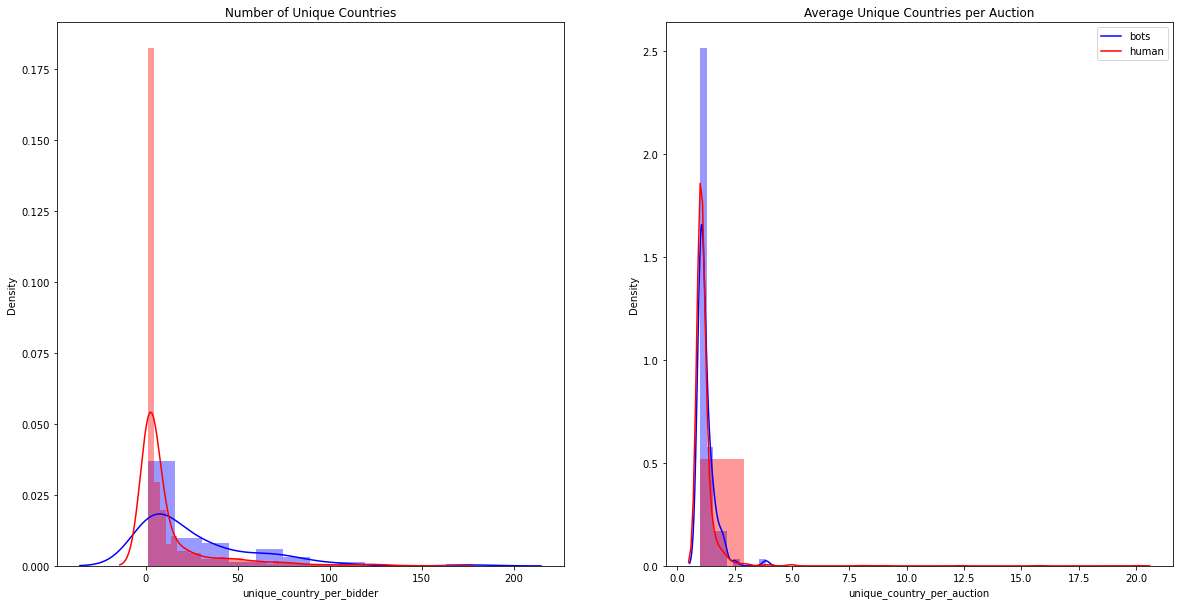

In [5]:
print("The number of unique countries in the dataset are:",df['country'].nunique())

# No. of unique countries for each bidder and in each auction
country_counts = (df.groupby(['bidder_id'])['country']
                  .nunique()
                  .rename('unique_country_per_bidder')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))

country_counts_auc = (df.groupby(['bidder_id','auction'])['country']
                  .nunique()
                  .reset_index()
                  .groupby('bidder_id')['country']
                  .mean()
                  .rename('unique_country_per_auction')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))  

fig, axes = plt.subplots(1,2, figsize=(20, 10))
sns.distplot(country_counts[country_counts['outcome_label']=='bot']['unique_country_per_bidder'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[0])
sns.distplot(country_counts[country_counts['outcome_label']=='human']['unique_country_per_bidder'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[0])
axes[0].set_title('Number of Unique Countries')
sns.distplot(country_counts_auc[country_counts_auc['outcome_label']=='bot']['unique_country_per_auction'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[1],bins=10)
sns.distplot(country_counts_auc[country_counts_auc['outcome_label']=='human']['unique_country_per_auction'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[1],bins=10)
axes[1].set_title('Average Unique Countries per Auction')
plt.legend(['bots', 'human'])
plt.show()



*   In general we see the bots using more number of unique countries for their bids from the first graph
*   Here we can see that since, the countries is a categorical variable, and since the count of countries is huge it would be better to implement **response coding**. 

* Along with we could include **number of unique countries per bidder**,**number of unique countries per auction** as features.Although, from the graphs we could observe that "per auction" doesn't seem to do too well.



## Device

The number of unique devices in the dataset are: 5729


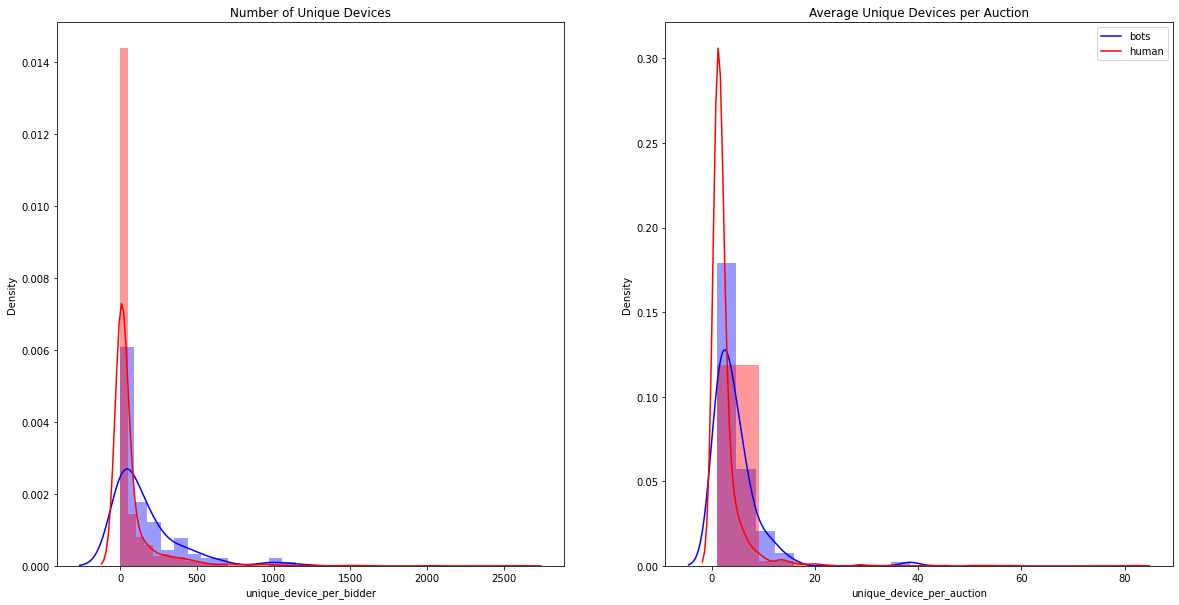

In [6]:
print("The number of unique devices in the dataset are:",df['device'].nunique())

# No. of unique countries for each bidder and in each auction
device_counts = (df.groupby(['bidder_id'])['device']
                  .nunique()
                  .rename('unique_device_per_bidder')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))

device_counts_auc = (df.groupby(['bidder_id','auction'])['device']
                  .nunique()
                  .reset_index()
                  .groupby('bidder_id')['device']
                  .mean()
                  .rename('unique_device_per_auction')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))  

fig, axes = plt.subplots(1,2, figsize=(20, 10))
sns.distplot(device_counts[device_counts['outcome_label']=='bot']['unique_device_per_bidder'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[0])
sns.distplot(device_counts[device_counts['outcome_label']=='human']['unique_device_per_bidder'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[0])
axes[0].set_title('Number of Unique Devices')
sns.distplot(device_counts_auc[device_counts_auc['outcome_label']=='bot']['unique_device_per_auction'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[1],bins=10)
sns.distplot(device_counts_auc[device_counts_auc['outcome_label']=='human']['unique_device_per_auction'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[1],bins=10)
axes[1].set_title('Average Unique Devices per Auction')
plt.legend(['bots', 'human'])
plt.show()



*   We can observe similar graphs to "country"
*   We observe that in unique device ber bidder, we see more devices used by the bots in comparison to humans, but in the second graph we could hardly see much difference.
* The number of unique devices are more than **5000** we should not consider one hot but rather maybe again response encoding.



## URL

### No of URLs

The number of unique urls in the dataset are: 663873


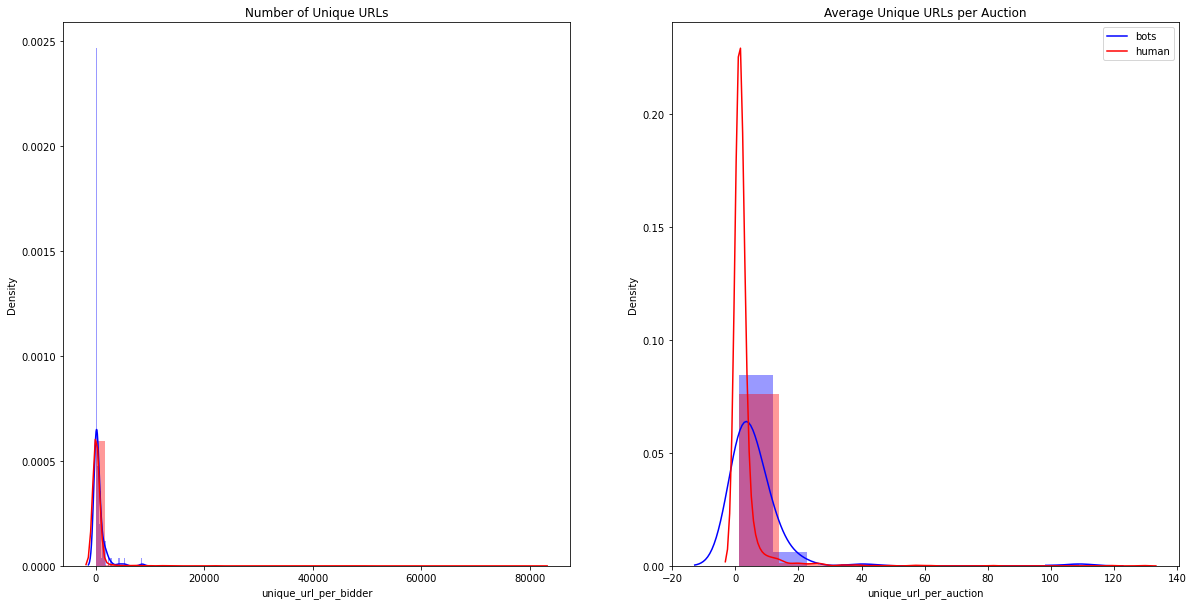

In [7]:
print("The number of unique urls in the dataset are:",df['url'].nunique())

# No. of unique countries for each bidder and in each auction
url_counts = (df.groupby(['bidder_id'])['url']
                  .nunique()
                  .rename('unique_url_per_bidder')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))

url_counts_auc = (df.groupby(['bidder_id','auction'])['url']
                  .nunique()
                  .reset_index()
                  .groupby('bidder_id')['url']
                  .mean()
                  .rename('unique_url_per_auction')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))  

fig, axes = plt.subplots(1,2, figsize=(20, 10))
sns.distplot(url_counts[url_counts['outcome_label']=='bot']['unique_url_per_bidder'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[0])
sns.distplot(url_counts[url_counts['outcome_label']=='human']['unique_url_per_bidder'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[0])
axes[0].set_title('Number of Unique URLs')
sns.distplot(url_counts_auc[url_counts_auc['outcome_label']=='bot']['unique_url_per_auction'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[1],bins=10)
sns.distplot(url_counts_auc[url_counts_auc['outcome_label']=='human']['unique_url_per_auction'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[1],bins=10)
axes[1].set_title('Average Unique URLs per Auction')
plt.legend(['bots', 'human'])
plt.show()



*   The number of unique urls used by humans and bots look similar, but the number of unique urls used per auction, we observe that bots tend to use more urls in comparison to humans.
*   The number of unique urls are above **660K**, and we could response encode them to our use.



### Main URL Usage

In [ ]:
df['url'].value_counts(normalize=True)

vasstdc27m7nks3    5.034019e-01
7zyltxp0hh36vpp    5.112945e-03
q0skvht51258k93    2.883541e-03
96ky12gxeqflpwz    2.431929e-03
gavdutxwg0vi1gn    2.073440e-03
                       ...     
56ma4le9bom6ey7    3.256031e-07
8e9qgft53ganj7o    3.256031e-07
fkmke5kodxd01i9    3.256031e-07
ofjy0e78pgy45jc    3.256031e-07
jn3ye4ixoauy2u8    3.256031e-07
Name: url, Length: 663873, dtype: float64

* We can observe that more than 50% of the bids are bid using a single url. We can consider this to be a main page URL. 
* Since, we observed that humans use lesser unique urls to make bids per auction, we can suspect them to use this url more often than bots

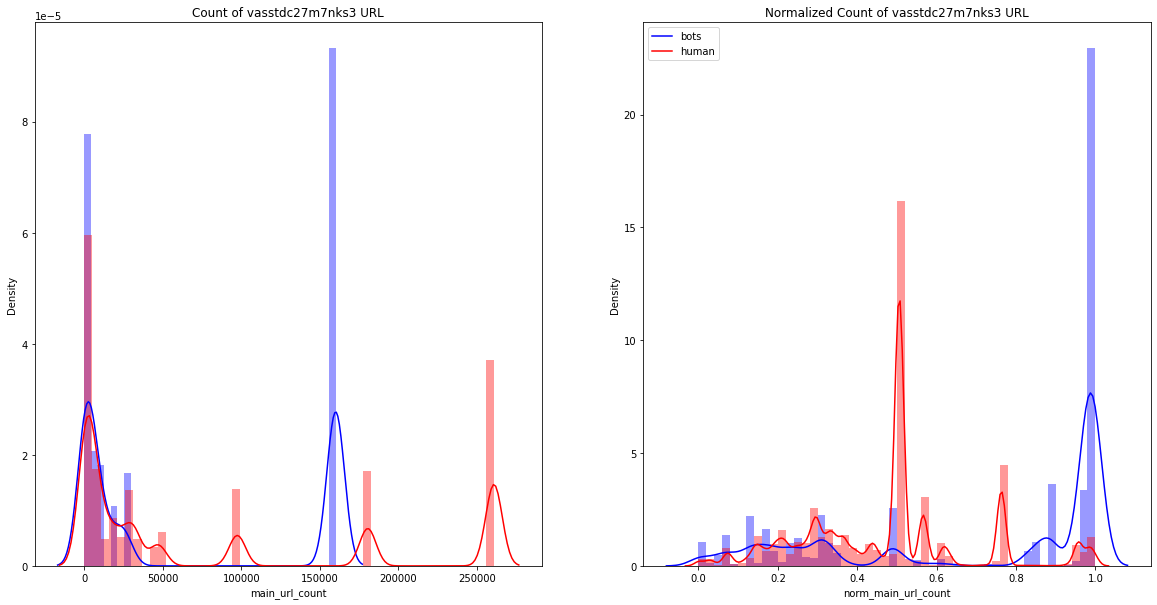

In [8]:
main_url_count = (df[df['url']=="vasstdc27m7nks3"]
                    .groupby(['bidder_id'])
                    .size()
                    .rename('main_url_count')
                    .reset_index()
                    .merge(df[['bidder_id','outcome_label']],on = 'bidder_id',how = 'right')
                    .fillna(0))
norm_main_url_count = (df.groupby('bidder_id')
                         .size()
                         .rename('bids')
                         .reset_index()
                         .merge(main_url_count,on = 'bidder_id',how = 'right'))
norm_main_url_count['norm_main_url_count'] = norm_main_url_count['main_url_count']/norm_main_url_count['bids']

fig, axes = plt.subplots(1,2, figsize=(20, 10))
sns.distplot(main_url_count[main_url_count['outcome_label']=='bot']['main_url_count'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[0])
sns.distplot(main_url_count[main_url_count['outcome_label']=='human']['main_url_count'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[0])
axes[0].set_title('Count of vasstdc27m7nks3 URL')
sns.distplot(norm_main_url_count[norm_main_url_count['outcome_label']=='bot']['norm_main_url_count'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[1])
sns.distplot(norm_main_url_count[norm_main_url_count['outcome_label']=='human']['norm_main_url_count'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[1])
axes[1].set_title('Normalized Count of vasstdc27m7nks3 URL')
plt.legend(['bots', 'human'])
plt.show()

* These are turning out to be excellent features as we can observe different spikes and usabillity by humans and bots
* We clearly observe from the second graph that bots tend to use more of the main url in comparison to humans. Although our what our expected hypothesis was differnet, but this is certainly very useful.

## IP Address

### No of IP Address

The number of unique ips in the dataset are: 1030950


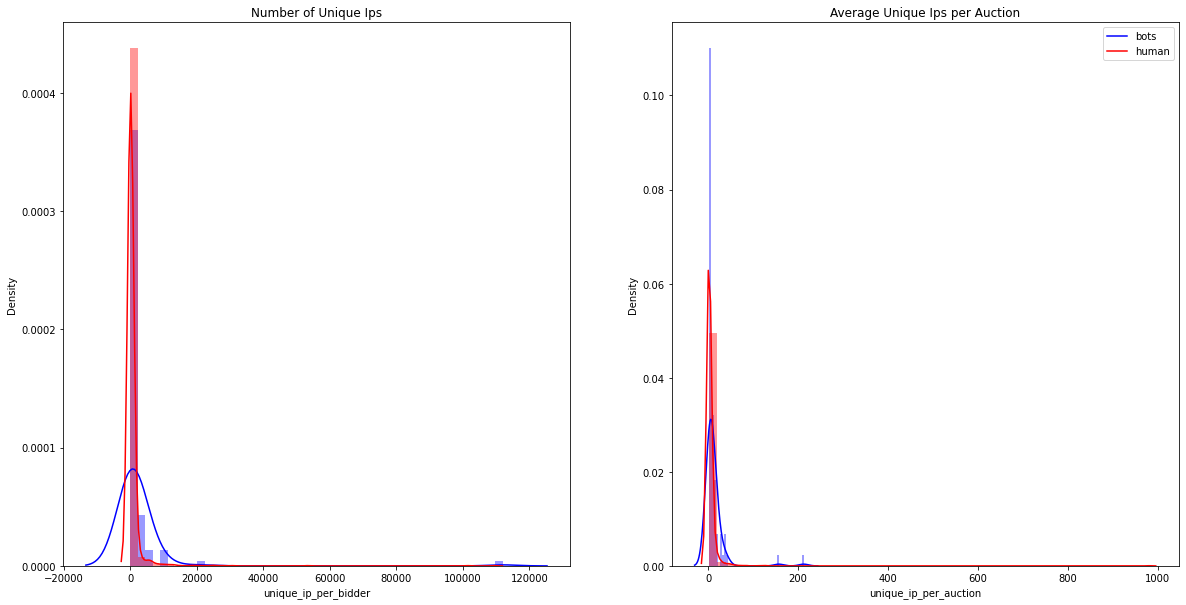

In [9]:
print("The number of unique ips in the dataset are:",df['ip'].nunique())

# No. of unique countries for each bidder and in each auction
ip_counts = (df.groupby(['bidder_id'])['ip']
                  .nunique()
                  .rename('unique_ip_per_bidder')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))

ip_counts_auc = (df.groupby(['bidder_id','auction'])['ip']
                  .nunique()
                  .reset_index()
                  .groupby('bidder_id')['ip']
                  .mean()
                  .rename('unique_ip_per_auction')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))  

fig, axes = plt.subplots(1,2, figsize=(20, 10))
sns.distplot(ip_counts[ip_counts['outcome_label']=='bot']['unique_ip_per_bidder'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[0])
sns.distplot(ip_counts[ip_counts['outcome_label']=='human']['unique_ip_per_bidder'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[0])
axes[0].set_title('Number of Unique Ips')
sns.distplot(ip_counts_auc[ip_counts_auc['outcome_label']=='bot']['unique_ip_per_auction'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[1])
sns.distplot(ip_counts_auc[ip_counts_auc['outcome_label']=='human']['unique_ip_per_auction'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[1])
axes[1].set_title('Average Unique Ips per Auction')
plt.legend(['bots', 'human'])
plt.show()

*   We can observe similar graphs to "country"
*   We observe that in unique ip ber bidder, we see more ips used by the bots in comparison to humans, but in the second graph we could hardly see much difference.
* The number of unique devices are more than **1M** we should not consider one hot but rather response encoding.


### IP Address Domain Knowledge:

![picture](https://drive.google.com/uc?id=1L33L9DFsQX8oX-fByqQsiLzY0ffmrVm8)

**Reference: https://docs.oracle.com/cd/E19504-01/802-5753/planning3-18471/index.html**

* The IP Address can be divided into two parts as shown in the image above,network and host part.
* If there are two bidders connected via a single network, their **Network Part** will be the same but the **Host Part** will be different.
* With the following information, we could make features, becuase just the ip with same network part and different host part will be categorized as different ip address. 

In [11]:
ip_address = df['ip'].str.split('.', expand = True)
df_ip = df.copy()
df_ip['ip_network'] = ip_address[0]+'.'+ip_address[1]
df_ip['ip_host'] = ip_address[2]+'.'+ip_address[3]

### IP Network

The number of unique ip_networks in the dataset are: 65536


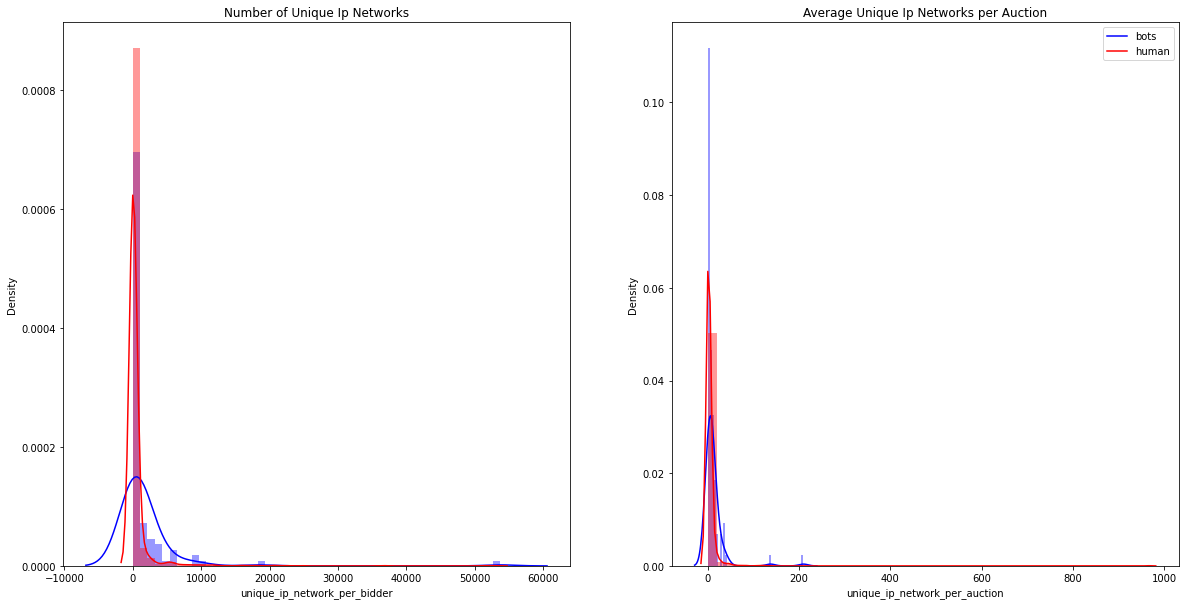

In [12]:
print("The number of unique ip_networks in the dataset are:",df_ip['ip_network'].nunique())

# No. of unique countries for each bidder and in each auction
ip_network_counts = (df_ip.groupby(['bidder_id'])['ip_network']
                  .nunique()
                  .rename('unique_ip_network_per_bidder')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))

ip_network_counts_auc = (df_ip.groupby(['bidder_id','auction'])['ip_network']
                  .nunique()
                  .reset_index()
                  .groupby('bidder_id')['ip_network']
                  .mean()
                  .rename('unique_ip_network_per_auction')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))  

fig, axes = plt.subplots(1,2, figsize=(20, 10))
sns.distplot(ip_network_counts[ip_network_counts['outcome_label']=='bot']['unique_ip_network_per_bidder'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[0])
sns.distplot(ip_network_counts[ip_network_counts['outcome_label']=='human']['unique_ip_network_per_bidder'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[0])
axes[0].set_title('Number of Unique Ip Networks')
sns.distplot(ip_network_counts_auc[ip_network_counts_auc['outcome_label']=='bot']['unique_ip_network_per_auction'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[1])
sns.distplot(ip_network_counts_auc[ip_network_counts_auc['outcome_label']=='human']['unique_ip_network_per_auction'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[1])
axes[1].set_title('Average Unique Ip Networks per Auction')
plt.legend(['bots', 'human'])
plt.show()

* The bots seem to be operating on different networks in comparison to humans as we can see from the first graph.
* The unique IP Networks are  around **65K** which in comparison the unique ip addresses was more than 1 million. This feature could be incorporated as response encoding.
* Based on Domain Knowledge, the dataset covers all the ip networks part possible(256*256)

### IP Host

The number of unique ip_hosts in the dataset are: 65536


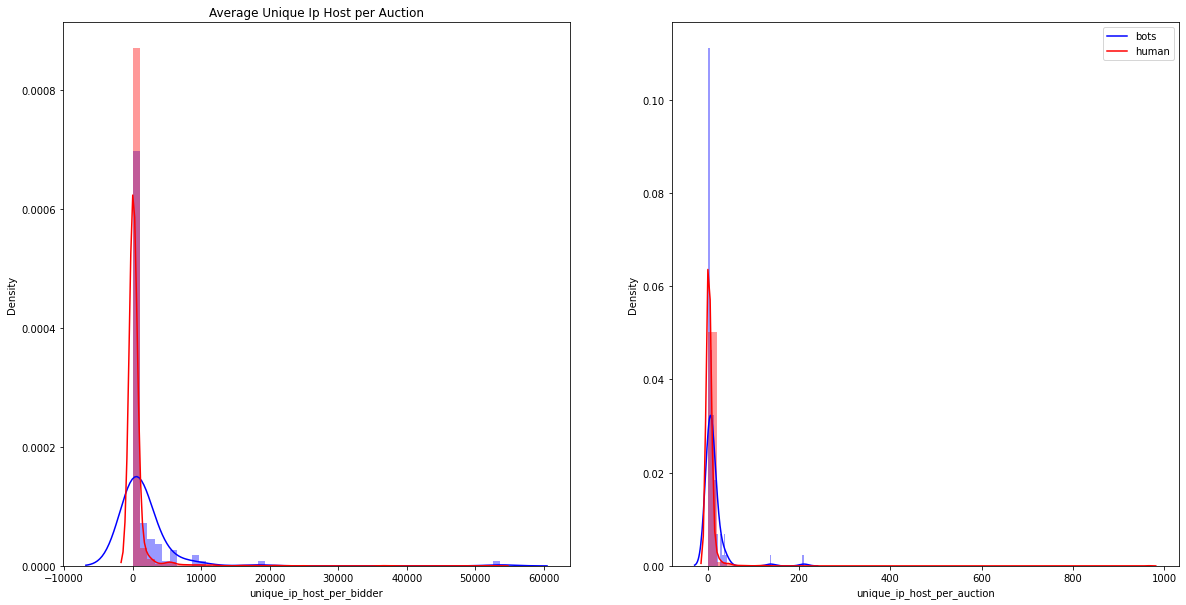

In [13]:
print("The number of unique ip_hosts in the dataset are:",df_ip['ip_host'].nunique())

# No. of unique countries for each bidder and in each auction
ip_host_counts = (df_ip.groupby(['bidder_id'])['ip_host']
                  .nunique()
                  .rename('unique_ip_host_per_bidder')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))

ip_host_counts_auc = (df_ip.groupby(['bidder_id','auction'])['ip_host']
                  .nunique()
                  .reset_index()
                  .groupby('bidder_id')['ip_host']
                  .mean()
                  .rename('unique_ip_host_per_auction')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))  

fig, axes = plt.subplots(1,2, figsize=(20, 10))
sns.distplot(ip_host_counts[ip_host_counts['outcome_label']=='bot']['unique_ip_host_per_bidder'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[0])
sns.distplot(ip_host_counts[ip_host_counts['outcome_label']=='human']['unique_ip_host_per_bidder'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[0])
axes[0].set_title('Number of Unique Ip Hosts')
sns.distplot(ip_host_counts_auc[ip_host_counts_auc['outcome_label']=='bot']['unique_ip_host_per_auction'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[1])
sns.distplot(ip_host_counts_auc[ip_host_counts_auc['outcome_label']=='human']['unique_ip_host_per_auction'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[1])
axes[0].set_title('Average Unique Ip Host per Auction')
plt.legend(['bots', 'human'])
plt.show()

* The bots seem to be operating on different hosts in comparison to humans as we can see from the first graph.
* The unique IP Networks are  around **65K** which in comparison the unique ip addresses was more than 1 million. This feature could be incorporated as response encoding.
* Based on Domain Knowledge, the dataset covers all the ip hosts part possible(256*256)

## Auction

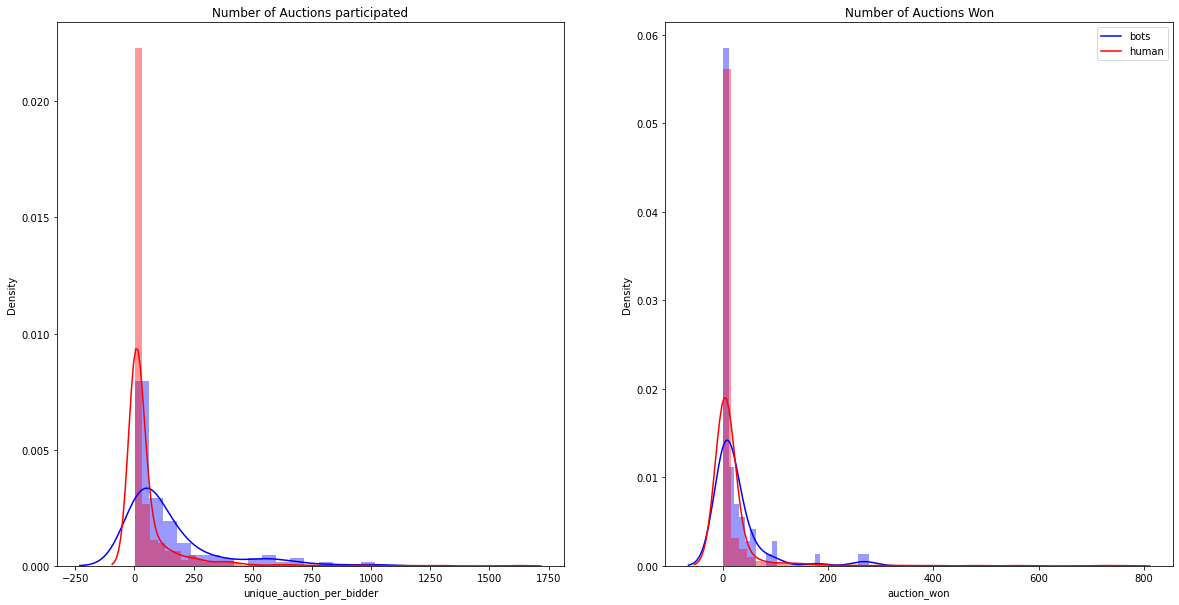

In [14]:
auction_counts = (df.groupby(['bidder_id'])['auction']
                  .nunique()
                  .rename('unique_auction_per_bidder')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))

# It is safe to believe that the last bid in an auction is the winner of the auction
auction_won = (df.sort_values(by = 'time')
                  .groupby('auction')
                  .tail(1)
                  .reset_index()
                  .groupby('bidder_id')
                  .size()
                  .rename('auction_won')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))

fig, axes = plt.subplots(1,2, figsize=(20, 10))
sns.distplot(auction_counts[auction_counts['outcome_label']=='bot']['unique_auction_per_bidder'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[0])
sns.distplot(auction_counts[auction_counts['outcome_label']=='human']['unique_auction_per_bidder'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[0])
axes[0].set_title('Number of Auctions participated')
sns.distplot(auction_won[auction_won['outcome_label']=='bot']['auction_won'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[1])
sns.distplot(auction_won[auction_won['outcome_label']=='human']['auction_won'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[1])
axes[1].set_title('Number of Auctions Won')
plt.legend(['bots', 'human'])
plt.show()

* From the first graph it is certain that the bots tend to participate in more auctions in comparison to humans as the curve for bots is much more spread in comparison to humans which is very steep.

* The second graph represents the auctions won by humans and bots, but the distributions are very similar, hence the auction won may not be the best criteria of analyzing the outcome.



## Bids

### No of Bids

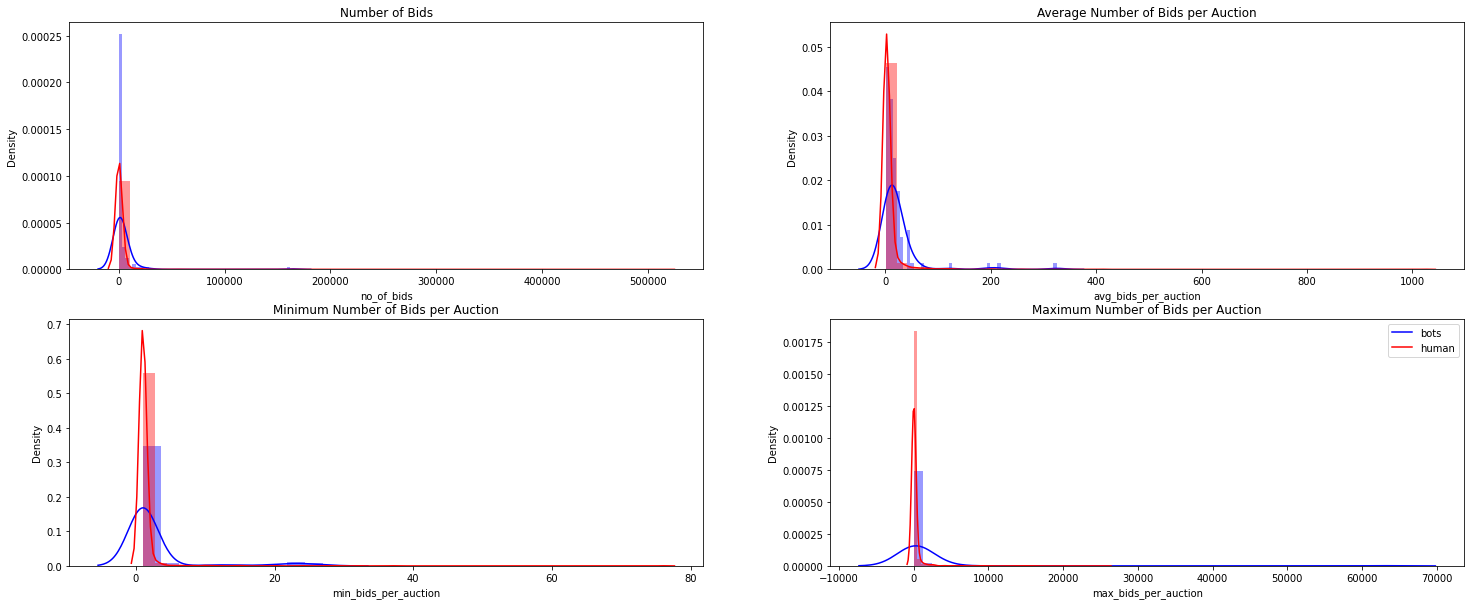

In [15]:
bids_counts = (df.groupby(['bidder_id'])
                .size()
                .rename('no_of_bids')
                .reset_index()
                .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))
bids_counts_avg = (df.groupby(['bidder_id','auction'])
                .size()
                .rename('avg_bids_per_auction')
                .reset_index()
                .groupby('bidder_id')['avg_bids_per_auction']
                .mean()
                .reset_index()
                .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))
bids_counts_min = (df.groupby(['bidder_id','auction'])
                .size()
                .rename('min_bids_per_auction')
                .reset_index()
                .groupby('bidder_id')['min_bids_per_auction']
                .min()
                .reset_index()
                .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))
bids_counts_max = (df.groupby(['bidder_id','auction'])
                .size()
                .rename('max_bids_per_auction')
                .reset_index()
                .groupby('bidder_id')['max_bids_per_auction']
                .max()
                .reset_index()
                .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))

fig, axes = plt.subplots(2,2, figsize=(25, 10))
sns.distplot(bids_counts[bids_counts['outcome_label']=='bot']['no_of_bids'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[0,0])
sns.distplot(bids_counts[bids_counts['outcome_label']=='human']['no_of_bids'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[0,0])
axes[0,0].set_title('Number of Bids')
sns.distplot(bids_counts_avg[bids_counts_avg['outcome_label']=='bot']['avg_bids_per_auction'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[0,1])
sns.distplot(bids_counts_avg[bids_counts_avg['outcome_label']=='human']['avg_bids_per_auction'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[0,1])
axes[0,1].set_title('Average Number of Bids per Auction')
sns.distplot(bids_counts_min[bids_counts_min['outcome_label']=='bot']['min_bids_per_auction'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[1,0])
sns.distplot(bids_counts_min[bids_counts_min['outcome_label']=='human']['min_bids_per_auction'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[1,0])
axes[1,0].set_title('Minimum Number of Bids per Auction')
sns.distplot(bids_counts_max[bids_counts_max['outcome_label']=='bot']['max_bids_per_auction'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[1,1])
sns.distplot(bids_counts_max[bids_counts_max['outcome_label']=='human']['max_bids_per_auction'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[1,1])
axes[1,1].set_title('Maximum Number of Bids per Auction')
plt.legend(['bots', 'human'])
plt.show()



*   The total number of bids and the average number of bids per auction also doesn't give us the best manner of differentiating humans from bots as the distributions are very common.
*   The minimum and the maximum number of auctions give some perspective to the picture that the bots have a greater range of values in minimum and maximum values but not very much.



### Bid Order

Bid order is defined as the order of bid with respect to time in each auction. The first ever bid in the following auction will be given bid_order=1, the last bid will be given n(total number of bids in the auction). The following will be normalized as a different feature.

In [16]:
bid_order_dict = {ix:1 for ix in df['auction'].unique()}
auction_count = df['auction'].value_counts()
def bid_update(auction):
  val = bid_order_dict[auction]
  norm_val = val/auction_count[auction]
  bid_order_dict[auction]+=1
  return val,norm_val

df['bid_order'],df['bid_order_norm'] = zip(*df['auction'].apply(lambda x: bid_update(x)))

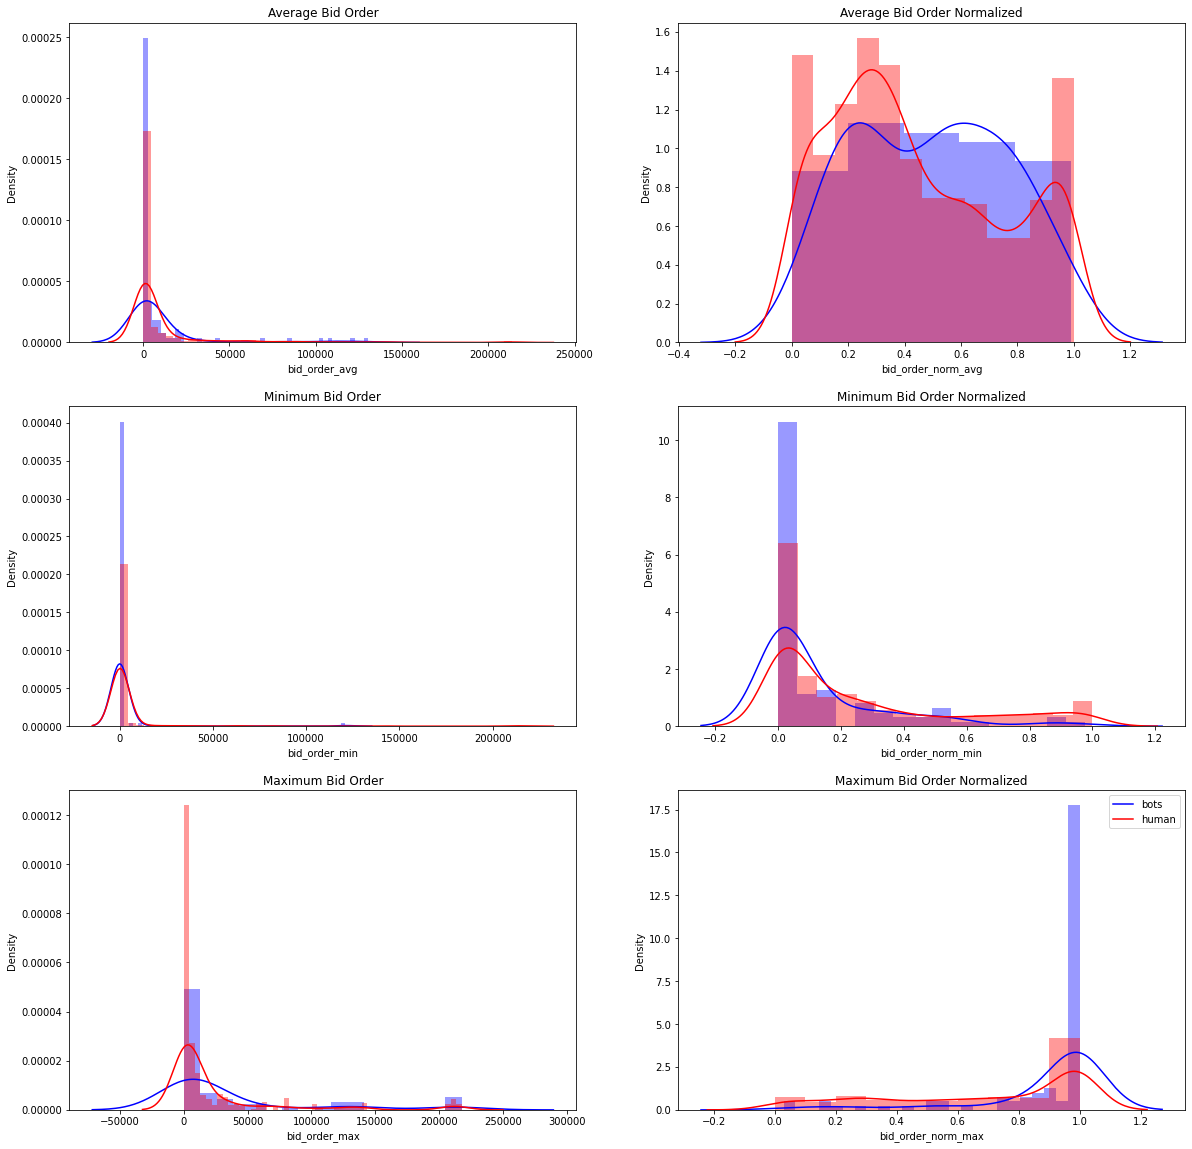

In [17]:
bid_order_avg = (df.groupby(['bidder_id'])['bid_order']
                  .mean()
                  .rename('bid_order_avg')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))
bid_order_norm_avg = (df.groupby(['bidder_id'])['bid_order_norm']
                  .mean()
                  .rename('bid_order_norm_avg')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))

bid_order_min = (df.groupby(['bidder_id'])['bid_order']
                  .min()
                  .rename('bid_order_min')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))
bid_order_norm_min = (df.groupby(['bidder_id'])['bid_order_norm']
                  .min()
                  .rename('bid_order_norm_min')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left')) 

bid_order_max = (df.groupby(['bidder_id'])['bid_order']
                  .max()
                  .rename('bid_order_max')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))
bid_order_norm_max = (df.groupby(['bidder_id'])['bid_order_norm']
                  .max()
                  .rename('bid_order_norm_max')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))
                          
fig, axes = plt.subplots(3,2, figsize=(20, 20))
sns.distplot(bid_order_avg[bid_order_avg['outcome_label']=='bot']['bid_order_avg'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[0,0])
sns.distplot(bid_order_avg[bid_order_avg['outcome_label']=='human']['bid_order_avg'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[0,0])
axes[0,0].set_title('Average Bid Order')
sns.distplot(bid_order_norm_avg[bid_order_norm_avg['outcome_label']=='bot']['bid_order_norm_avg'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[0,1])
sns.distplot(bid_order_norm_avg[bid_order_norm_avg['outcome_label']=='human']['bid_order_norm_avg'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[0,1])
axes[0,1].set_title('Average Bid Order Normalized')
sns.distplot(bid_order_min[bid_order_min['outcome_label']=='bot']['bid_order_min'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[1,0])
sns.distplot(bid_order_min[bid_order_min['outcome_label']=='human']['bid_order_min'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[1,0])
axes[1,0].set_title('Minimum Bid Order')
sns.distplot(bid_order_norm_min[bid_order_norm_min['outcome_label']=='bot']['bid_order_norm_min'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[1,1])
sns.distplot(bid_order_norm_min[bid_order_norm_min['outcome_label']=='human']['bid_order_norm_min'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[1,1])
axes[1,1].set_title('Minimum Bid Order Normalized')
sns.distplot(bid_order_max[bid_order_max['outcome_label']=='bot']['bid_order_max'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[2,0])
sns.distplot(bid_order_max[bid_order_max['outcome_label']=='human']['bid_order_max'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[2,0])
axes[2,0].set_title('Maximum Bid Order')
sns.distplot(bid_order_norm_max[bid_order_norm_max['outcome_label']=='bot']['bid_order_norm_max'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[2,1])
sns.distplot(bid_order_norm_max[bid_order_norm_max['outcome_label']=='human']['bid_order_norm_max'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[2,1])
axes[2,1].set_title('Maximum Bid Order Normalized')
plt.legend(['bots', 'human'])
plt.show()

* The normalized bid order stats is being helpful to distinguish bot and human. We can observe the average normalized bid order is able to succesfully distinguish between human and bot.

* The bid order min has a very similar pattern. The curves is similar for humans and bots.

* The bid order max normalized for a bot has a lot more value of 1, while the human values are a lot more spread. 

## Time

### Time Difference

Time Difference is defined as the quantity of time taken for bids for each auction by the bidder.We will calculate the basic stats(mean,min and max) of time difference for each bidder.

In [18]:
time_diff_dict = {ix:iy for ix,iy in zip(sorted(df['auction'].unique()),df.groupby('auction')['time'].min())}
def time_update(row):
  val = row[1]-time_diff_dict[row[0]]
  time_diff_dict[row[0]] = row[1]
  return val

df['time_diff'] = df[['auction','time']].sort_values(by = 'time').apply(lambda x: time_update(x),axis=1)

#Normalized Time Difference
min_max_scaler = preprocessing.MinMaxScaler()
df['time_diff_norm'] = min_max_scaler.fit_transform(df['time_diff'].to_numpy().reshape(-1,1))

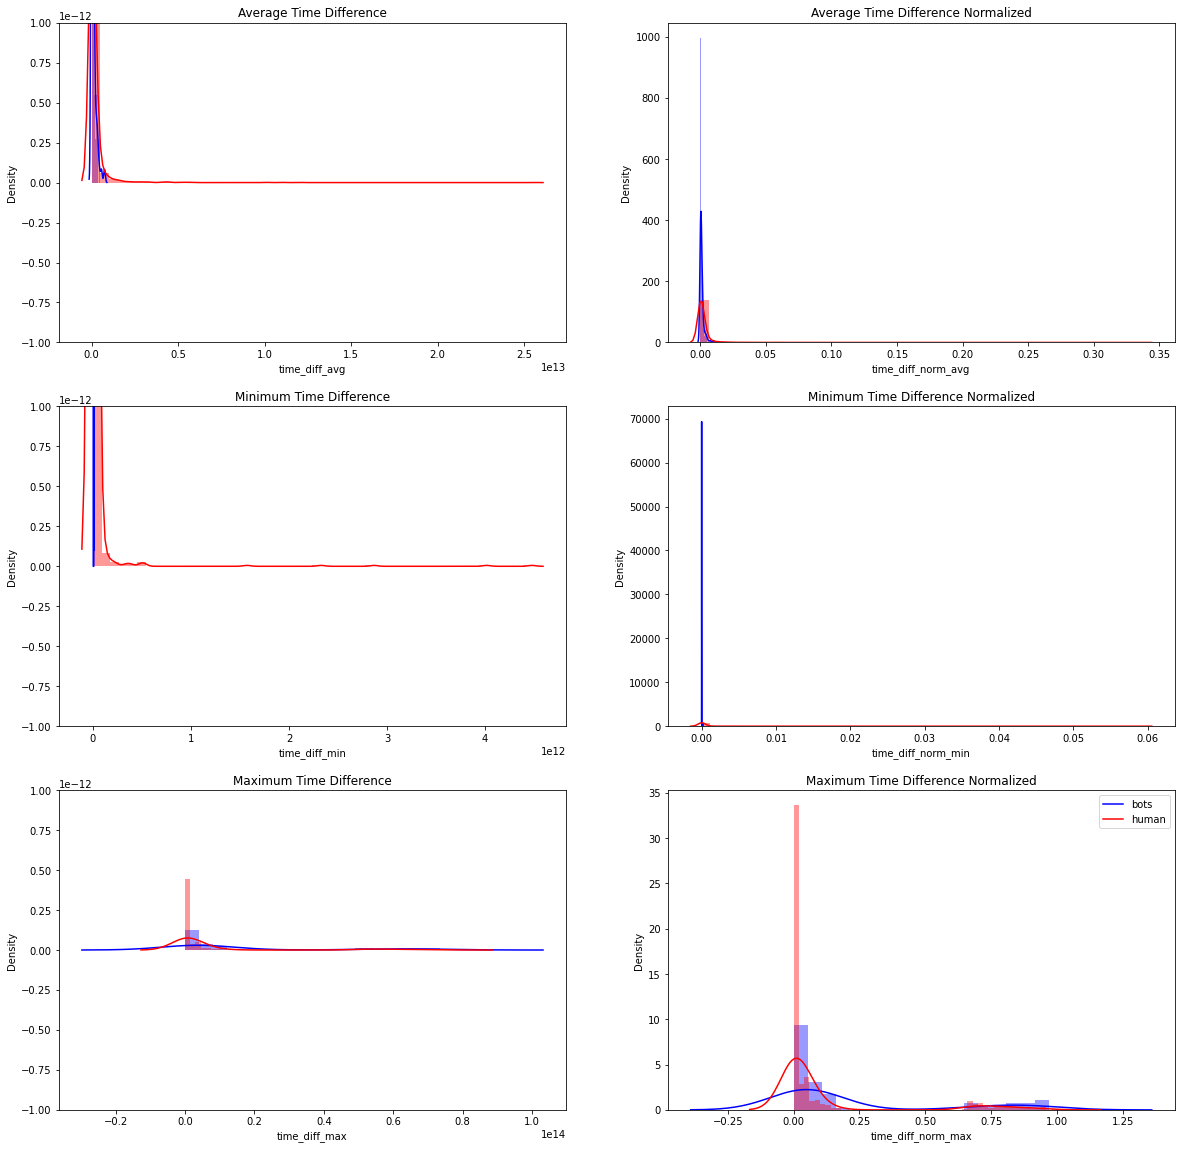

In [19]:
time_diff_avg = (df.groupby(['bidder_id'])['time_diff']
                  .mean()
                  .rename('time_diff_avg')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))
time_diff_norm_avg = (df.groupby(['bidder_id'])['time_diff_norm']
                  .mean()
                  .rename('time_diff_norm_avg')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))

time_diff_min = (df.groupby(['bidder_id'])['time_diff']
                  .min()
                  .rename('time_diff_min')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))
time_diff_norm_min = (df.groupby(['bidder_id'])['time_diff_norm']
                  .min()
                  .rename('time_diff_norm_min')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left')) 

time_diff_max = (df.groupby(['bidder_id'])['time_diff']
                  .max()
                  .rename('time_diff_max')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))
time_diff_norm_max = (df.groupby(['bidder_id'])['time_diff_norm']
                  .max()
                  .rename('time_diff_norm_max')
                  .reset_index()
                  .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))
                          
fig, axes = plt.subplots(3,2, figsize=(20, 20))
sns.distplot(time_diff_avg[time_diff_avg['outcome_label']=='bot']['time_diff_avg'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[0,0])
sns.distplot(time_diff_avg[time_diff_avg['outcome_label']=='human']['time_diff_avg'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[0,0])
axes[0,0].set_title('Average Time Difference')
sns.distplot(time_diff_norm_avg[time_diff_norm_avg['outcome_label']=='bot']['time_diff_norm_avg'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[0,1])
sns.distplot(time_diff_norm_avg[time_diff_norm_avg['outcome_label']=='human']['time_diff_norm_avg'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[0,1])
axes[0,1].set_title('Average Time Difference Normalized')
sns.distplot(time_diff_min[time_diff_min['outcome_label']=='bot']['time_diff_min'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[1,0])
sns.distplot(time_diff_min[time_diff_min['outcome_label']=='human']['time_diff_min'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[1,0])
axes[1,0].set_title('Minimum Time Difference')
sns.distplot(time_diff_norm_min[time_diff_norm_min['outcome_label']=='bot']['time_diff_norm_min'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[1,1])
sns.distplot(time_diff_norm_min[time_diff_norm_min['outcome_label']=='human']['time_diff_norm_min'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[1,1])
axes[1,1].set_title('Minimum Time Difference Normalized')
sns.distplot(time_diff_max[time_diff_max['outcome_label']=='bot']['time_diff_max'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[2,0])
sns.distplot(time_diff_max[time_diff_max['outcome_label']=='human']['time_diff_max'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[2,0])
axes[2,0].set_title('Maximum Time Difference')
sns.distplot(time_diff_norm_max[time_diff_norm_max['outcome_label']=='bot']['time_diff_norm_max'],
            color='blue',kde_kws={'linewidth': 1.5},ax=axes[2,1])
sns.distplot(time_diff_norm_max[time_diff_norm_max['outcome_label']=='human']['time_diff_norm_max'], 
             color='red',kde_kws={'linewidth': 1.5},ax=axes[2,1])
axes[2,1].set_title('Maximum Time Difference Normalized')
plt.legend(['bots', 'human'])
plt.show()



*  The time difference minimum normalized is a very helpful feature as we can observe, because time difference min is very concentrated for a bot around 0.0, while humans have a spread over humans time difference.

* The time difference maximum normalized has a more spread values for a bot in comparison to humans.

* On an average, the bot takes much lesser time in comparison to humans.



### Activity in Time Slots

* We are going to observe the activity of bidder in the whole range of time provided in the dataset.

* To observe this activity, we are going to divide the entire range of time into multiple bins. We could experiment with the number of bins which give the best results. Between each of bin of time, if a bidder has bid on anything we will respond with an activity=**1** and keep on incrementing based on the entire datset.

* For a bot to bid, there should be a pattern in which the bot bids and this could easily be essential to detect using the activity in the time slots.

In [ ]:
print('Range of time in the given dataset: {} to {}'.format(min(df['time']),max(df['time'])))
print('Difference in time range: {}'.format(max(df['time'])-min(df['time'])))

Range of time in the given dataset: 9631916842105263 to 9772885210526315
Difference in time range: 140968368421052


In [ ]:
bin_range = np.ceil((max(df['time'])-min(df['time']))/1000)
df['time_slot'] = np.floor((df['time']-min(df['time']))/bin_range)
print('Unique time slots are: {}'.format(len(df['time_slot'].unique())))

Unique time slots are: 292


In [ ]:
activity_time_slot = (df.groupby(['bidder_id','time_slot'])
                        .size()
                        .unstack('time_slot', fill_value=0)
                        .reset_index()
                        .merge(train[['bidder_id','outcome_label']],on = 'bidder_id',how = 'left'))
# PCA dimensionality reduction for visualization of importance of activity slots
pca = PCA(0.98)
x = activity_time_slot.drop(['bidder_id','outcome_label'],axis=1)
x_pca = pd.DataFrame(pca.fit_transform(x))
x_pca['outcome_label'] = activity_time_slot['outcome_label']

Text(0.5, 1.08, 'Pair Plot for PCA features of Activity in time slots')

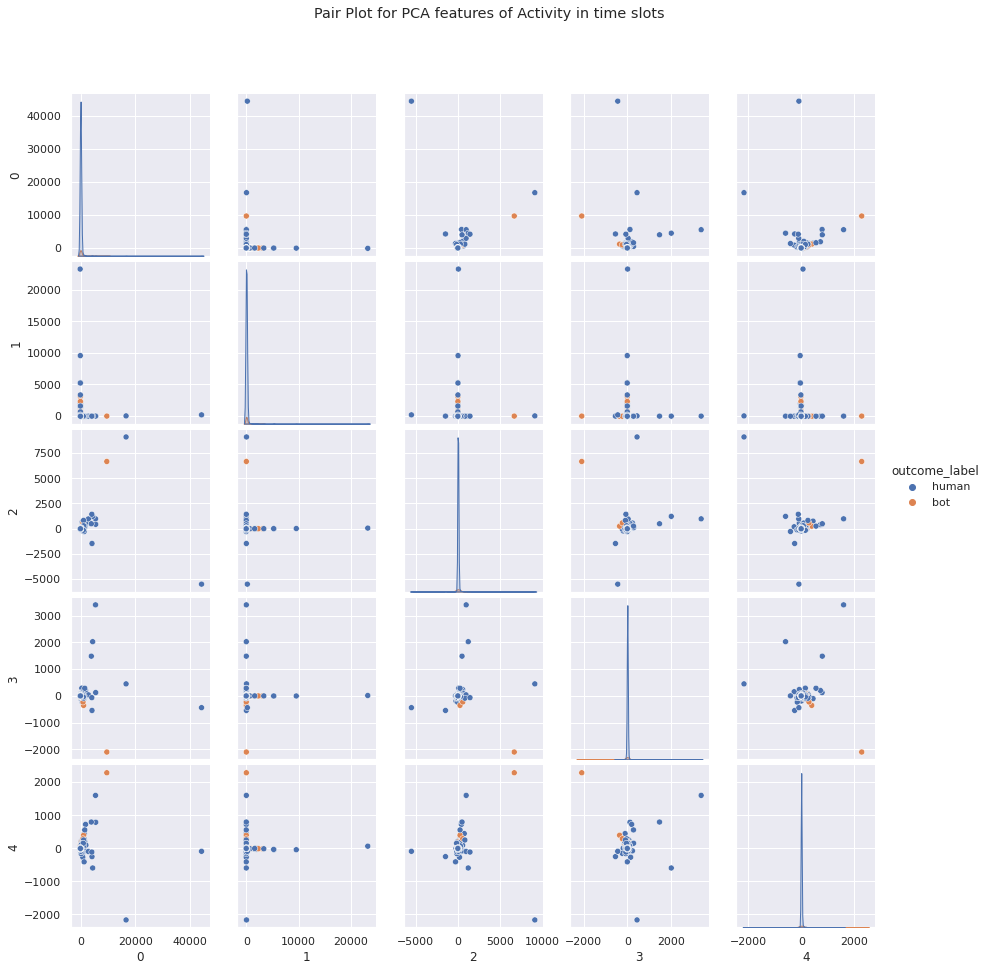

In [ ]:
g = sns.pairplot(x_pca,hue='outcome_label')
g.fig.suptitle('Pair Plot for PCA features of Activity in time slots', y=1.08)



*   As you can see from the pair plots between pca features of time slots features produced, there is no conclusive evidence to differentiate between humans and bots.

* This maybe because the dataset is highly imbalanced to have any clear check, we could probably test with a simple linear model(such as Logistic Regression) to see how good the features are training on just the activity features.



In [ ]:
nbBins = [100,1000,10000]
c = [1,1e-1,1e-2,1e-3]
for iy in c:
    clf = LogisticRegression(random_state=42,C=iy)
    print('Lambda for Logistic Regression model is: {}'.format(iy))
    print(' ')
    for ix in nbBins:
          bin_range = np.ceil((max(df['time'])-min(df['time']))/ix)
          df['time_slot'] = np.floor((df['time']-min(df['time']))/bin_range)
          print('Unique time slots {} for bins {}'.format(len(df['time_slot'].unique()),ix))

          activity_time_slot = (df.groupby(['bidder_id','time_slot'])
                                .size()
                                .unstack('time_slot', fill_value=0)
                                .reset_index()
                                .merge(train[['bidder_id','outcome']],on = 'bidder_id',how = 'left'))
          X,y = activity_time_slot.drop(['bidder_id','outcome'],axis=1),activity_time_slot['outcome'].copy()
          X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y)
          clf.fit(X_train,y_train)
          score = roc(y_test,clf.predict_proba(X_test)[:, 1])
          print('The AUC test score with {} bins is {}'.format(ix,score))
          print(' ')
    print("*"*100)

Lambda for Logistic Regression model is: 1
 
Unique time slots 30 for bins 100
The AUC test score with 100 bins is 0.5460992907801419
 
Unique time slots 292 for bins 1000
The AUC test score with 1000 bins is 0.47543059777102326
 
Unique time slots 2904 for bins 10000
The AUC test score with 10000 bins is 0.6680597771023302
 
****************************************************************************************************
Lambda for Logistic Regression model is: 0.1
 
Unique time slots 30 for bins 100
The AUC test score with 100 bins is 0.47606382978723405
 
Unique time slots 292 for bins 1000
The AUC test score with 1000 bins is 0.6155015197568388
 
Unique time slots 2904 for bins 10000
The AUC test score with 10000 bins is 0.767223910840932
 
****************************************************************************************************
Lambda for Logistic Regression model is: 0.01
 
Unique time slots 30 for bins 100
The AUC test score with 100 bins is 0.5044959473150963
 
Un



*   As we can see just by using a linear model and training on just time slots and tuning based on lambda values of Logistic Regression we got the best AUC score of **0.8**
*   This proves that although we didn't tune our entire model with just Time Slots we are able to get a great auc score, proving this to be a very important feature for us to train on.
* This activy based features could be processed through fourier decomposition or other wave based featurization to extract better information.

